In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import random

In [5]:
import pandas as pd
import numpy as np
import random
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [6]:
# List of sample names
names = ["Ramesh", "Suresh", "Hitesh", "Mukesh", "Rajesh", "Mahesh", "Pankaj", "Sanjay", "Vikas", "Amit", "Karan", "Arjun"]

# Generate student dataset
num_students = 10000
students = pd.DataFrame({
    'Student_ID': range(1, num_students + 1),
    'Name': [random.choice(names) + " " + random.choice(["Sharma", "Verma", "Patel", "Yadav", "Gupta"]) for _ in range(num_students)]
})

print(students.head())  # Display first 5 students

   Student_ID          Name
0           1   Karan Patel
1           2  Suresh Gupta
2           3  Pankaj Verma
3           4  Mukesh Verma
4           5  Mahesh Patel


In [7]:
spark = SparkSession.builder.appName("ResultManagement").getOrCreate()
students_spark = spark.createDataFrame(students)

In [8]:
subjects = ["Electronics", "Programming", "Database", "Data Science", "Mathematics", "DSA"]

In [9]:
marks_data = []
for student in students_spark.collect():
    student_id = student.Student_ID
    marks_row = {"Student_ID": student_id}
    for subject in subjects:
        marks_row[subject] = random.randint(0, 100)
    marks_data.append(Row(**marks_row))

In [10]:
marks_df = spark.createDataFrame(marks_data)

In [11]:
student_marks_df = students_spark.join(marks_df, "Student_ID")

In [12]:
for subject in subjects:
    student_marks_df = student_marks_df.withColumn(f"{subject}_Grade", F.when(F.col(subject) >= 90, "A").when(F.col(subject) >= 80, "B").when(F.col(subject) >= 70, "C").when(F.col(subject) >= 60, "D").otherwise("F"))

average_marks = student_marks_df.select([F.mean(col).alias(f"Average_{col}") for col in subjects])

In [13]:
average_marks.show()

+-------------------+-------------------+----------------+--------------------+-------------------+-----------+
|Average_Electronics|Average_Programming|Average_Database|Average_Data Science|Average_Mathematics|Average_DSA|
+-------------------+-------------------+----------------+--------------------+-------------------+-----------+
|            50.3807|             50.456|         50.1149|             49.8349|            49.6946|    50.0513|
+-------------------+-------------------+----------------+--------------------+-------------------+-----------+



In [14]:
statistics = student_marks_df.select([F.stddev(col).alias(f"StdDev_{col}") for col in subjects] + [F.min(col).alias(f"Min_{col}") for col in subjects] + [F.max(col).alias(f"Max_{col}") for col in subjects])
statistics.show()

+------------------+------------------+------------------+-------------------+------------------+----------------+---------------+---------------+------------+----------------+---------------+-------+---------------+---------------+------------+----------------+---------------+-------+
|StdDev_Electronics|StdDev_Programming|   StdDev_Database|StdDev_Data Science|StdDev_Mathematics|      StdDev_DSA|Min_Electronics|Min_Programming|Min_Database|Min_Data Science|Min_Mathematics|Min_DSA|Max_Electronics|Max_Programming|Max_Database|Max_Data Science|Max_Mathematics|Max_DSA|
+------------------+------------------+------------------+-------------------+------------------+----------------+---------------+---------------+------------+----------------+---------------+-------+---------------+---------------+------------+----------------+---------------+-------+
| 29.31426785952554|29.004289146243345|29.169319205430448|   29.1931338827572| 28.98824525003654|29.1102698216782|              0|         

In [15]:
for subject in subjects:
    top_performers = student_marks_df.orderBy(F.col(subject).desc()).select("Student_ID", "Name", subject).limit(5)
    print(f"Top performers in {subject}:")
    top_performers.show()

Top performers in Electronics:
+----------+-------------+-----------+
|Student_ID|         Name|Electronics|
+----------+-------------+-----------+
|       414|Hitesh Sharma|        100|
|      4108| Mahesh Verma|        100|
|      1526| Mahesh Gupta|        100|
|        26| Mahesh Verma|        100|
|       823|Rajesh Sharma|        100|
+----------+-------------+-----------+

Top performers in Programming:
+----------+-------------+-----------+
|Student_ID|         Name|Programming|
+----------+-------------+-----------+
|      2235| Vikas Sharma|        100|
|      1733|  Vikas Yadav|        100|
|      1722| Ramesh Gupta|        100|
|      2812|  Karan Patel|        100|
|       768|Mahesh Sharma|        100|
+----------+-------------+-----------+

Top performers in Database:
+----------+-------------+--------+
|Student_ID|         Name|Database|
+----------+-------------+--------+
|      1362|Hitesh Sharma|     100|
|      2522| Arjun Sharma|     100|
|      1440| Rajesh Verma|

In [16]:
average_marks_pd = average_marks.toPandas()
statistics_pd = statistics.toPandas()

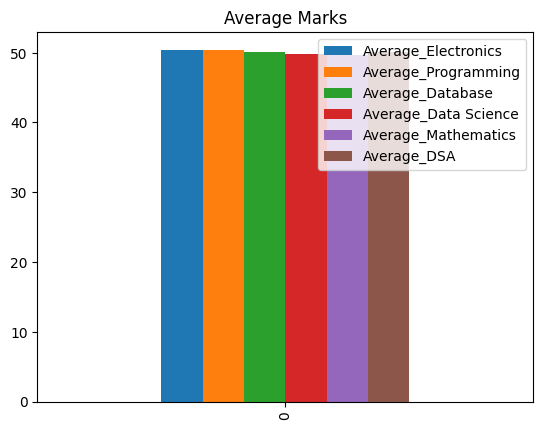

In [17]:
average_marks_pd.plot(kind='bar', title='Average Marks')
plt.show()

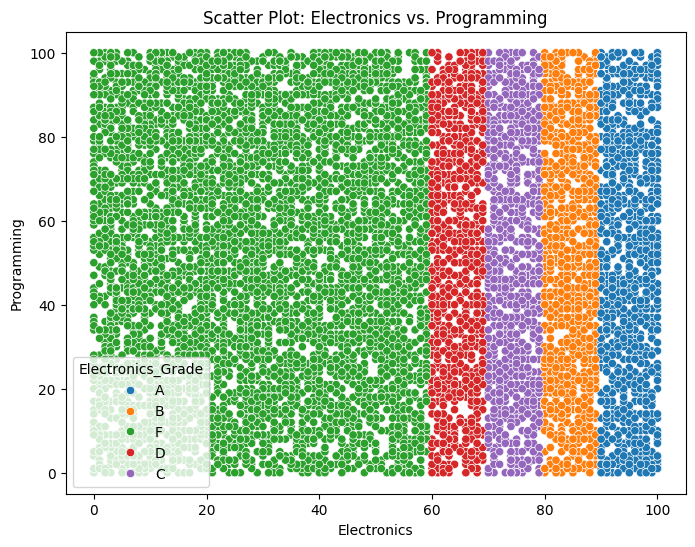

In [26]:
# Scatter Plot (Example: Electronics vs. Programming)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Electronics', y='Programming', data=student_marks_pd, hue='Electronics_Grade')
plt.title('Scatter Plot: Electronics vs. Programming')
plt.show()

spark.stop()

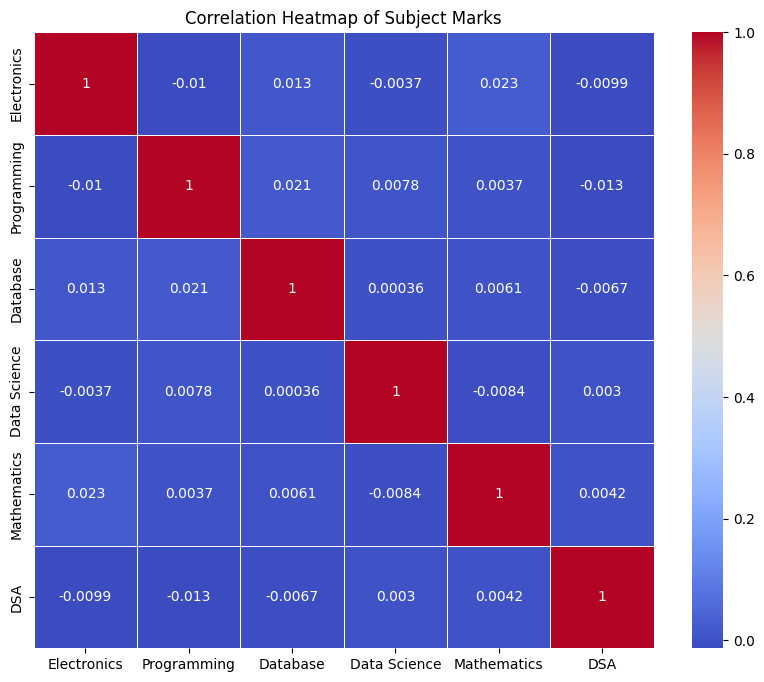

In [28]:
subjects_marks = student_marks_pd[subjects]
plt.figure(figsize=(10, 8))
sns.heatmap(subjects_marks.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Subject Marks')
plt.show()

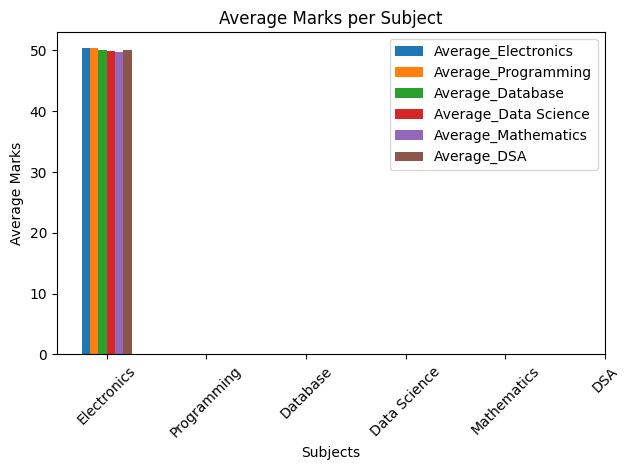

In [29]:
average_marks_pd.plot(kind='bar', title='Average Marks per Subject')
plt.xlabel('Subjects')
plt.ylabel('Average Marks')
plt.xticks(range(len(subjects)), subjects, rotation=45)
plt.tight_layout()
plt.show()

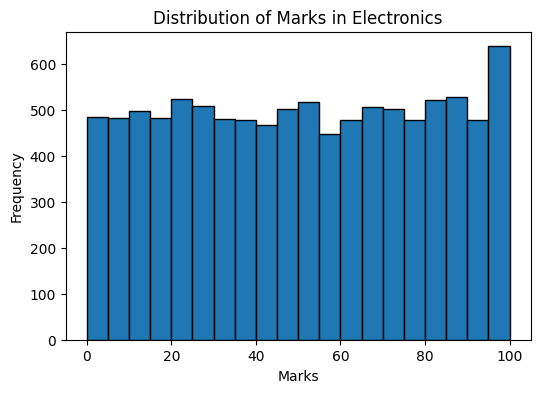

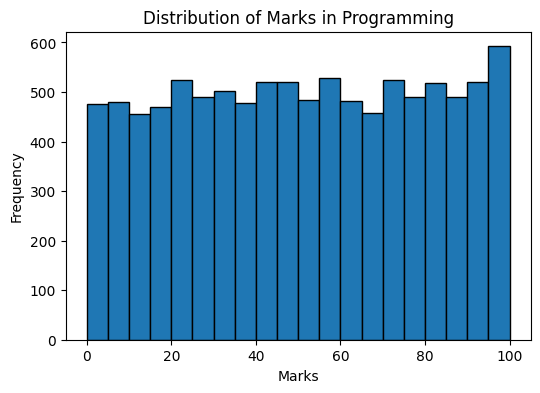

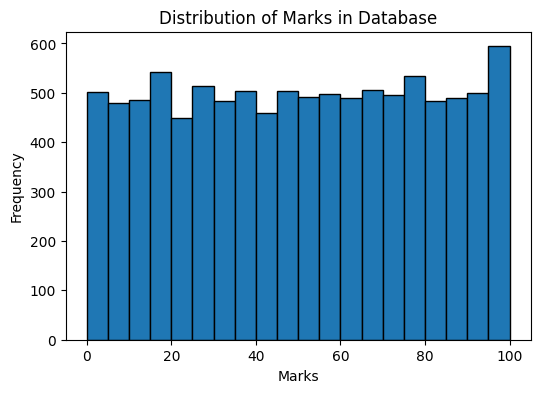

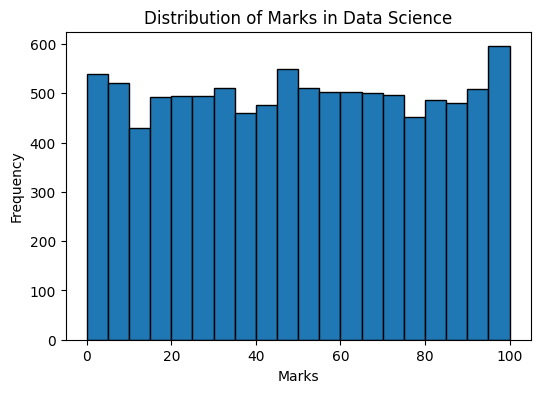

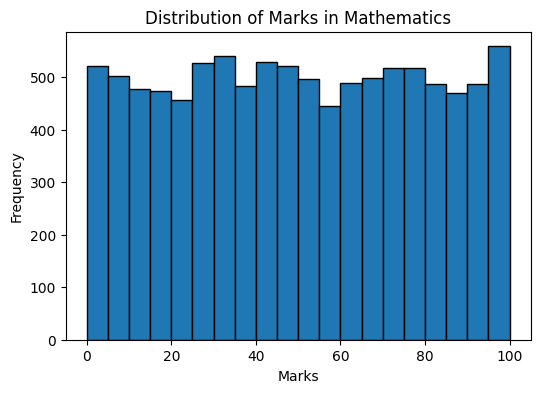

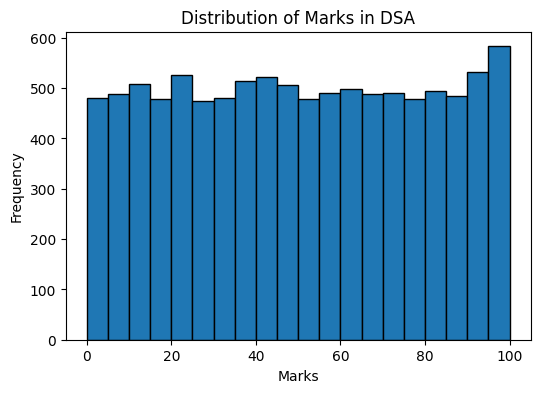

In [30]:
for subject in subjects:
    plt.figure(figsize=(6, 4))
    plt.hist(student_marks_pd[subject], bins=20, edgecolor='black')
    plt.title(f'Distribution of Marks in {subject}')
    plt.xlabel('Marks')
    plt.ylabel('Frequency')
    plt.show()